# Metropolis-Hastings algorithm

This notebook implements a Metropolis-Hastings sampler, and applies it to a simple 2-dimensional probability density function.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

Define the logarithm of the probability density that we want to sample from. We make use of the "Rosenbrock function," which is commonly used to illustrate Markov Chain Monte Carlo:

$$
  f \left( x, y \right) = \left(a-x\right)^2 + b \left(y-x^2\right)^2 \\
  \ln p \left( x, y \right) = - \frac{1}{2} f \left( x, y \right) + \mathrm{const} \, .
$$

Note that the probability density function is not normalized (i.e., it does not integrate to 1). This is not a problem, as the MCMC methods work just fine with un-normalized probability densities.

In [2]:
def rosenbrock(x, a=1, b=2):
    return (a-x[...,0])**2 + b * (x[...,1]-x[...,0]**2)**2

def lnp(x):
    return -0.5 * rosenbrock(x)

We plot the probability density function in 2D:

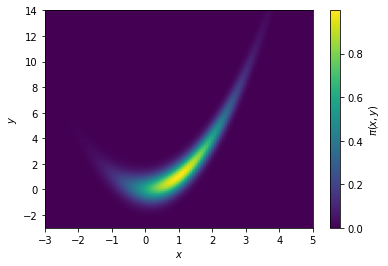

In [3]:
xlim = (-3, 5)
ylim = (-3, 14)

x_grid = np.linspace(xlim[0], xlim[1], 100)
y_grid = np.linspace(ylim[0], ylim[1], 100)
x_grid,y_grid = np.meshgrid(x_grid, y_grid)

xy_grid = np.stack([x_grid, y_grid], axis=2)

extent = xlim + ylim

p = np.exp(lnp(xy_grid))

plt.imshow(p, aspect='auto', origin='lower', extent=extent)
plt.colorbar(label=r'$\pi\left(x,y\right)$')

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.show()

For the Metropolis-Hastings algorithm, we have to define a proposal distribution, $Q \left( \vec{x}^{\prime} \mid \vec{x} \right)$. We choose to make this a 2D Gaussian centered on $\vec{x}$, with width $\sigma$. The following function takes $\vec{x}$ and returns a new candidate state, $\vec{x}^{\prime}$:

In [4]:
def Q(x, sigma=1.0):
    return x + sigma * rng.normal(size=x.size)

Below, we implement the Metropolis-Hastings algorithm. The number of steps (`n_steps`) and the typical scale of each step (`sigma`) can be modified:

In [5]:
n_steps = 1000 #@param {type:"integer"}
sigma =  1.0 #@param {type:"number"}

# Initialize the random-number generator
rng = np.random.default_rng()

# Choose initial state randomly.
# We intentionally choose a bad starting point, just to illustrate
# how burn-in works.
x_chain = [np.array([0.,10.]) + rng.uniform(-1, 1, size=2)]
lnp_chain = [lnp(x_chain[-1])]

# Keep track of how many proposals are accepted
n_accepted = 0

for k in range(n_steps):
    # Current state, x
    x_cur = x_chain[-1]
    lnp_cur = lnp_chain[-1]

    # Generate proposal, x'
    x_prime = Q(x_cur, sigma=sigma)
    lnp_prime = lnp(x_prime)
    
    # Metropolis-Hastings acceptance rule
    if lnp_prime > lnp_cur:
        step = True
    elif rng.uniform(0,1) < np.exp(lnp_prime-lnp_cur):
        step = True
    else:
        step = False
    
    if step:
        # Step to proposal
        n_accepted += 1
        x_chain.append(x_prime)
        lnp_chain.append(lnp_prime)
    else:
        # Don't step.
        # Add current state to the chain again.
        x_chain.append(x_cur)
        lnp_chain.append(lnp_cur)

# Convert the list of arrays to a single array
x_chain = np.array(x_chain)

In [6]:
accept_pct = 100 * n_accepted / n_steps
print(f'{accept_pct}% of steps accepted.')

32.4% of steps accepted.


Plot the samples in the chain on top of the probability density function:

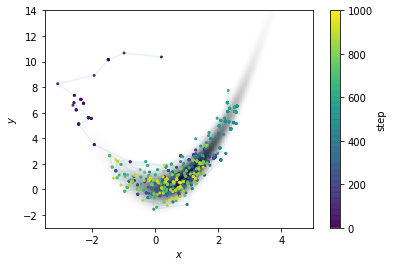

In [7]:
xlim = (-3, 5)
ylim = (-3, 14)

x_grid = np.linspace(xlim[0], xlim[1], 100)
y_grid = np.linspace(ylim[0], ylim[1], 100)
x_grid,y_grid = np.meshgrid(x_grid, y_grid)

xy_grid = np.stack([x_grid, y_grid], axis=2)

extent = xlim + ylim

p = np.exp(lnp(xy_grid))

plt.imshow(p, aspect='auto', origin='lower', extent=extent, cmap='binary')
# plt.colorbar(label=r'$\pi\left(x,y\right)$')

plt.plot(x_chain[:,0], x_chain[:,1], alpha=0.1)
plt.scatter(x_chain[:,0], x_chain[:,1], alpha=0.8, s=4, c=np.arange(x_chain.shape[0]))
plt.colorbar(label='step')

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.show()

Plot the sampled $x$ and $y$ (i.e., the two coordinates of $\vec{x}$) as a function of the sampling step:

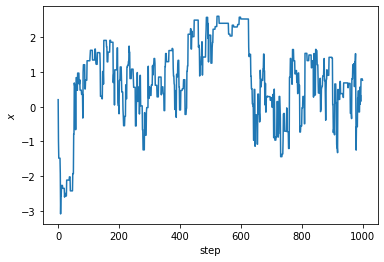

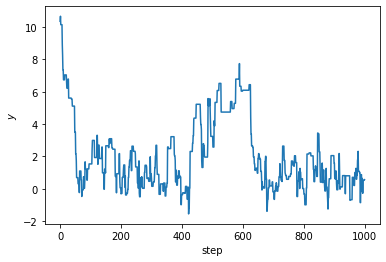

In [8]:
plt.plot(x_chain[:,0])
plt.xlabel('step')
plt.ylabel(r'$x$')
plt.show()

plt.plot(x_chain[:,1])
plt.xlabel(r'step')
plt.ylabel(r'$y$')
plt.show()

Calculate the mean and standard deviation of the chain. We exclude the first quarter of the chain ("burn-in"), in order to make sure that our starting position does not affect the results:

In [9]:
mu = np.mean(x_chain[n_steps//4:], axis=0)
sigma = np.std(x_chain[n_steps//4:], axis=0)

print(f'{mu} +- {sigma}')

[0.9101919  1.88139726] +- [1.02489726 2.08887551]


# Questions to consider

1. Does it look like the chain has converged? Do the statistics of the chain change if you increase the number of steps?

2. Can you come up with a way of automatically determining if the chain has converged?

3. How does the chain change if you modify the step scale, `sigma`?

4. Is the 2D Gaussian approximation to the chain that we calculate above a good representation of the probability density?

# Using a standard MCMC sampling package

Now, we'll use a standard package used (especially in astrophysics) for MCMC sampling: [`emcee`](https://emcee.readthedocs.io/en/stable/).

First, we have to install and import the package:

In [10]:
! pip install emcee

In [11]:
import emcee

There are many different MCMC sampling algorithms. Metropolis-Hastings is simple, but it's usually not the most effective algorithm. The `emcee` package implements a somewhat more advanced sampler that uses multiple "walkers" to explore the probability distribution. Below, we use 20. We also set the number of burn-in steps and subsequent sampling steps to take:

In [12]:
n_walkers = 20 #@param {type:"integer"}
n_burn_in = 1000 #@param {type:"integer"}
n_steps = 10000 #@param {type:"integer"}

n_dim = 2

Choose a starting point for the different walkers. The shape of this array has to be `(n_walkers, n_dim)`:

In [13]:
x0 = rng.normal(size=(n_walkers,n_dim))

Sample from the probability density function:

In [14]:
# Set up the sampler.
# It needs the number of walkers, the dimensionality of the space,
# and the log(probability) function.
sampler = emcee.EnsembleSampler(n_walkers, n_dim, lnp)

# Burn-in
state = sampler.run_mcmc(x0, n_burn_in)

# Delete the chain stored by the sampler
sampler.reset()

# Sample, starting from where the burn-in left off
_ = sampler.run_mcmc(state, n_steps)

# Get the chain.
# We "thin" the chain by taking every 100th sample.
chain = sampler.get_chain(flat=True, thin=100)

Plot the samples, on top of the probability density function:

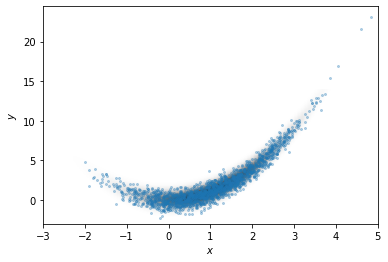

In [15]:
xlim = (-3, 5)
ylim = (-3, 14)

x_grid = np.linspace(xlim[0], xlim[1], 100)
y_grid = np.linspace(ylim[0], ylim[1], 100)
x_grid,y_grid = np.meshgrid(x_grid, y_grid)

xy_grid = np.stack([x_grid, y_grid], axis=2)

extent = xlim + ylim

p = np.exp(lnp(xy_grid))

plt.imshow(p, aspect='auto', origin='lower', extent=extent, cmap='binary')

plt.scatter(chain[:,0], chain[:,1], alpha=0.3, s=4)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.show()

As this sampler uses an ensemble of walkers, we can look at the chain produced by each walker separately. First, we get the ensemble of chains from the `sampler` object:

In [16]:
chain_ensemble = sampler.get_chain(thin=10)

The shape of the output is `(n_steps, n_walkers, n_dim)`:

In [17]:
chain_ensemble.shape

(1000, 20, 2)

We can plot each walker's chain separately. Change the `walker_idx` below to plot different walkers:

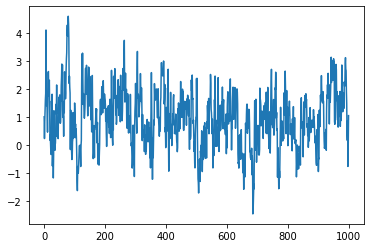

In [18]:
walker_idx = 0
plt.plot(chain_ensemble[:,walker_idx,0])
plt.show()